# Оценка рыночной стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. Это приложение позволяет быстро узнать рыночную стоимость автомобиля. В распоряжении имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо разработать модель для определения стоимости.

Критерии, важные для заказчика:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Инструкция по выполнению проекта

Чтобы исследование было более всесторонним, используем не только градиентный бустинг. Попробуем также более простые модели, так как иногда они обеспечивают лучшие результаты.

### Основные шаги:

1. Загрузить данные из файла: /datasets/autos.csv.
2. Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Удалите неинформативные признаки.
3. Подготовить выборки для обучения моделей.
4. Обучить различные модели, обязательно включая LightGBM и одну модель, которая не использует бустинг. Протестировать разные гиперпараметры для каждой модели.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Выбрать лучшую модель согласно критериям заказчика и проверить её качество на тестовой выборке.

### Примечания:

- Использовать метрику RMSE для оценки качества моделей.
- RMSE должен быть меньше 2500.
- Изучить библиотеку LightGBM и использовать её для построения моделей градиентного бустинга.
- Для измерения времени выполнения ячейки кода в Jupyter Notebook используйте специальную команду.
- Ограничиться изменением двух или трёх параметров для модели градиентного бустинга, так как она может долго обучаться.


del features_train


### Описание данных

Данные находятся в файле /datasets/autos.csv.

Признаки:
- _DateCrawled_ — дата скачивания анкеты из базы
- _VehicleType_ — тип автомобильного кузова
- _RegistrationYear_ — год регистрации автомобиля
- _Gearbox_ — тип коробки передач
- _Power_ — мощность (л. с.)
- _Model_ — модель автомобиля
- _Kilometer_ — пробег (км)
- _RegistrationMonth_ — месяц регистрации автомобиля
- _FuelType_ — тип топлива
- _Brand_ — марка автомобиля
- _Repaired_ — была машина в ремонте или нет
- _DateCreated_ — дата создания анкеты
- _NumberOfPictures_ — количество фотографий автомобиля
- _PostalCode_ — почтовый индекс владельца анкеты (пользователя)
- _LastSeen_ — дата последней активности пользователя

Целевой признак:
- _Price_ — цена (евро)

Было произведено объединение данных датафреймов `market`, `money`, `time` в отдельных датафрейм с разделением данных о времени и выручке за каждый период в разные столбцы

## Настройка переменных и окружения, импорты библиотек

In [1]:
import sys
!pip install phik -q
!pip install LightGBM -q

In [2]:
!pip install --upgrade scikit-learn==1.3.2 -q
!pip install --upgrade numpy==1.26.4 -q
!pip install --upgrade seaborn==0.13.0 -q
!pip install --upgrade phik==0.12.4 -q
!pip install --upgrade pandas==2.1.4 -q
!pip install --upgrade scipy==1.12.0 -q
!pip install --upgrade matplotlib==3.8.0 -q

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from math import log

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier


from lightgbm import LGBMRegressor

In [4]:
sns.set_theme()
sns.set_palette('Set2')
RANDOM_STATE = 5

## Подготовка данных

### Загрузка данных и первый взгляд

In [5]:
if os.path.exists('/datasets/autos.csv'):
    autos = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
    print('Dataset have read succesfully')
elif os.path.exists('./datasets/autos.csv'):
    autos = pd.read_csv('./datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
    print('Dataset have read succesfully')
else:
    print('Something went wrong')

Dataset have read succesfully


In [6]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Рассмотрим какие данные находятся в датафреме - для этого рассмотрим строки в начале, конце и рандомные

In [7]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [8]:
autos.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
128594,2016-03-21 18:36:43,16400,sedan,2007,auto,286,5er,150000,10,gasoline,bmw,no,2016-03-21,0,61169,2016-03-26 09:45:05
290881,2016-03-24 19:37:01,2650,sedan,1998,manual,150,3er,150000,5,NaN,bmw,NaN,2016-03-24,0,10559,2016-04-07 14:58:04
258613,2016-04-03 17:50:41,13990,convertible,2010,manual,140,3_reihe,70000,3,gasoline,peugeot,no,2016-04-03,0,64753,2016-04-05 18:17:26
71340,2016-03-17 18:45:44,9500,small,2010,manual,95,one,70000,6,petrol,mini,no,2016-03-17,0,41515,2016-03-28 23:15:27
10789,2016-03-06 19:38:13,1250,convertible,1996,manual,115,3er,150000,12,petrol,bmw,NaN,2016-03-06,0,14776,2016-03-12 14:17:25


In [9]:
autos.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20,0,40764,2016-03-24 12:45:21


### Анализ дубликатов и пропусков

Рассмотрим, какие существуют уникальные названия для категориальных признаков, а также выведем инфрормацию о полных дубликатах и пропусках

In [10]:
def get_info(data: pd.DataFrame) -> None:
    '''
    Function for printing base information of dataframe
    :param data: dataframe for search
    '''
    print('Info about data:')
    data.info()
    print('\nInfo about missing data:\n', data.isna().sum())
    print('\nInfo about duplicates:\n', data.duplicated().sum())

In [11]:
get_info(autos)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 n

In [12]:
def get_unique_values_with_counts(data: pd.DataFrame, col: pd.Series) -> str:
    """
    get values and their names into one str line
    params: data: dataframe for research
            col: column from dataframe for research
    return: str line with names and values
    """
    unique_values = data[col].unique()
    value_counts = data[col].value_counts()
    result = [f'{value} ({count})' for value, count in zip(unique_values, value_counts)]
    return ', '.join(result)


def unique_data(data: pd.DataFrame) -> None:
    """
    Output of unique data if it's count less tan ten
    params: data: dataframe for research
    """
    for col in data:
        if data[col].dtype == 'O' :
            print(f'{col}: {get_unique_values_with_counts(data, col)}\n')

In [13]:
unique_data(autos)

VehicleType: nan (91457), coupe (79831), suv (65166), small (28775), sedan (20203), convertible (16163), bus (11996), wagon (3288)

Gearbox: manual (268251), auto (66285)

Model: golf (29232), nan (24421), grand (19761), fabia (13066), 3er (12570), 2_reihe (10809), other (10146), c_max (9900), 3_reihe (8312), passat (7868), navara (6785), ka (6122), polo (5874), twingo (5774), a_klasse (5541), scirocco (4953), 5er (4822), meriva (4816), arosa (4337), c4 (4254), civic (4193), transporter (3601), punto (3546), e_klasse (3514), clio (3493), kadett (3470), kangoo (3347), corsa (3044), one (2910), fortwo (2702), 1er (2702), b_klasse (2594), signum (2108), astra (2080), a8 (1950), jetta (1830), fiesta (1758), c_klasse (1604), micra (1595), vito (1589), sprinter (1483), 156 (1446), escort (1416), forester (1364), xc_reihe (1347), scenic (1306), a4 (1304), a1 (1278), insignia (1226), combo (1223), focus (1156), tt (1076), a6 (1052), jazz (1033), omega (1017), slk (1014), 7er (958), 80 (953), 1

In [14]:
autos.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000,354369
mean,2016-03-21 12:58:10.450648320,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248,NaN


Рассмотрим все дублирующиеся строки в датафрейме

In [15]:
autos[autos.duplicated(keep=False)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


В датафрейме присутствуют полные дубликаты - на следующем этапе необходимо будет рассмотреть как от них избавится или оставить 

*Вывод*:
- Для продажи автомобилей с пробегом определенно важны такие параметры как `VehicleType`, `Power`, `Gearbox`, `Model`, `Kilometer`, `FuelType`, `Brand` и конечно же `Repaired`. Это те характеристики, которые будут влиять на ценообразование машины, бывшей в употреблении. Большая часть параметров будет влиять даже на стоимость автомобилей из салона.
- На стоимость продажи не должны влиять такие параметры, как `PostalCode`, `LastSeen`, `DateCrawled`, `NumberOfPictures`, `RegistrationMonth` - поскольку они скорее могут влиять на скорость продажи автомобиля, но не на его стоимость. Соответственно `PostalCode`, `LastSeen`, `NumberOfPictures`, `RegistrationMonth` можно удалить из анализа
- `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` являются категориальными признаками
- Для признаков, которые влияют на стоимость автомобиля заметны пропуски в данных: для признаков `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`, также для количественных признаков, таких как `Price`, `Power`, `RegistrationMonth` и `NumberOfPictures` есть нулевые значения
- Для датасета найдено большое количество данных, необходимо принять решение о том, каким образом стоит с ними поступить - не повлияет ли избавление от них слишком сильно на предсказание.

### Предобработка данных

Рассмотрим внимательнее данные с пропусками и нулевыми значениями: Для начала проанализируем количественные характеристики, среди которых также присутствует таргет

In [16]:
def plot_distribution(df: pd.DataFrame, feature: str, feat_ru: str):
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    if df[feature].dtype == 'int64' and len(df[feature].unique()) < 20:
        sns.countplot(data=df, x=feature, ax=axes[0])
    else:
        sns.histplot(data=df, x=feature, kde=True, ax=axes[0], bins=round(log((len(df[feature].unique()) + 1))*2, ))
        sns.boxplot(data=df, x=feature, ax=axes[1])
        fig.suptitle(f'Распределение для {feat_ru}')
    for num in range(2):
        axes[num].set_ylabel('Количество')
        axes[num].set_xlabel(feat_ru)

#### Количественные признаки

Рассмотрим количество объявлений с нулевой ценой и какое количество от общих данных оно занимает

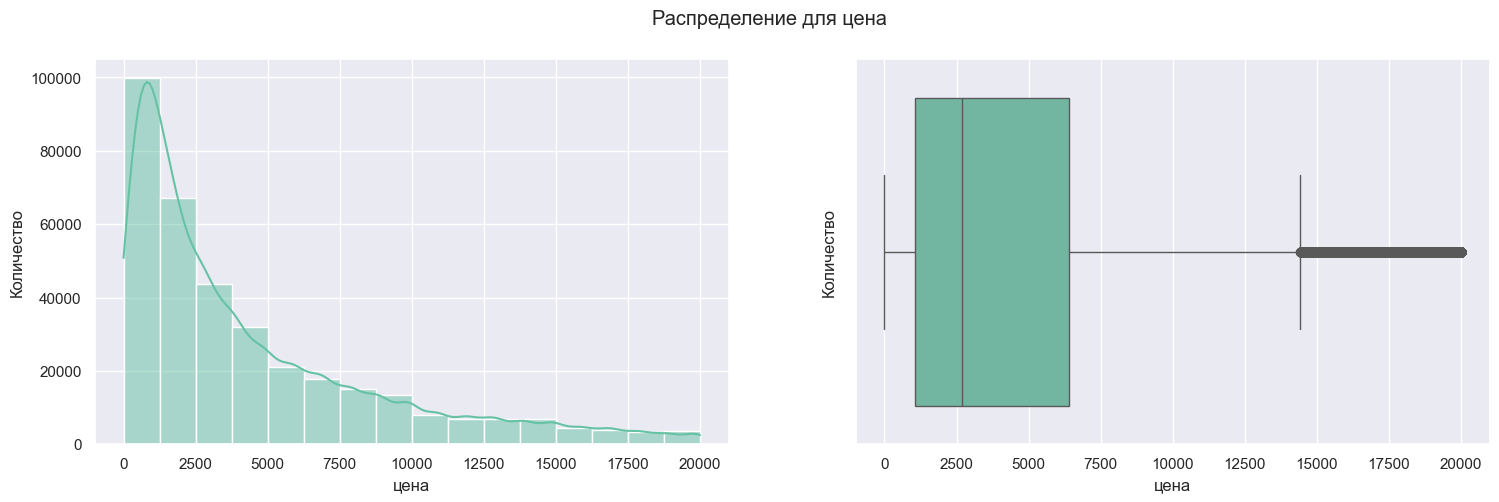

In [17]:
plot_distribution(autos, 'Price', 'цена')

In [18]:

print(f"Кол-во нулевых строчек для признака цена: {len(autos.query('Price == 0'))}, их процент от общего числа {round(len(autos.query('Price == 0')) / (autos['Price'].shape[0]) * 100)}%")

Кол-во нулевых строчек для признака цена: 10772, их процент от общего числа 3%


Поскольку процент для цены маленький - данные можно спокойно удалить, тем более что это таргет

In [19]:
autos = autos.query('Price != 0')

Далее рассмотрим на то, как распределены данные для мощности, которая является ценообразующим признаком

In [20]:
print(f"Кол-во нулевых строчек для признака цена: {len(autos.query('Power == 0'))}, их процент от общего числа {round(len(autos.query('Power == 0')) / (autos['Power'].shape[0]) * 100)}%")

Кол-во нулевых строчек для признака цена: 36360, их процент от общего числа 11%


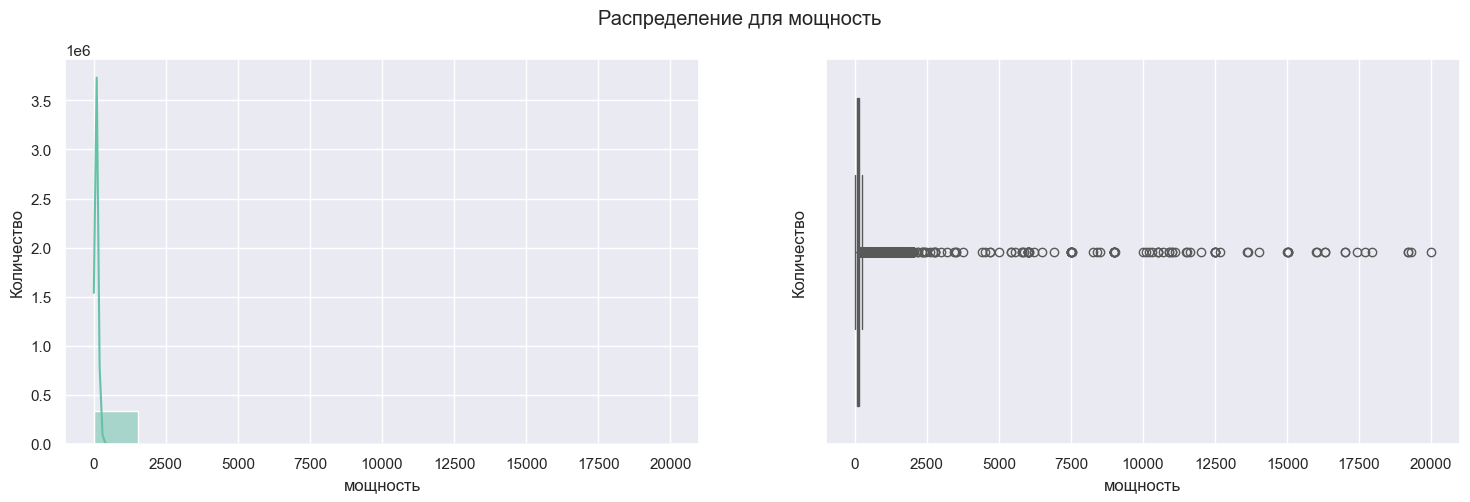

In [21]:
plot_distribution(autos, 'Power', 'мощность')

Поскольку на данный момент самая большая мощность автомобиля у Lotus Evija 2023 года выпуска - 2012 лошадиных сил, необходимо также изменить данные, которые указывают мощность выше этой. Ограничим релевантные данные до 1100 лошадиных сил - для остальных необходимо заменить значение.

Поскольку у каждого бренда свое название модели и для каждой модели свои характеристики автомобиля, а также это коррелирующие между собой параметры, рассмотрим параметры мощности для различных моделей

In [22]:
pd.pivot_table(autos, values='Power', index='Model', aggfunc=['std', 'median', 'mean', 'max', 'min']).sample(15)

,std,median,mean,max,min
,Power,Power,Power,Power,Power
Model,,,,,
156,48.119764,150.0,137.610927,250,0
s_max,31.241010,140.0,152.387471,254,0
kaefer,66.353428,34.0,36.111905,1300,0
voyager,54.681140,147.0,123.565916,218,0
colt,42.241723,75.0,80.472813,953,0
terios,29.429648,105.0,86.685714,105,0
cordoba,31.738172,75.0,66.898172,150,0
berlingo,413.116700,90.0,100.891892,9012,0


Для заполнения данных используем медианное значение - поскольку у большинства моделей присутствуют нули или экстремально большие значения, и чтобы избежать влияния этих данных на заменяемое значение, будем использовать медиану

In [23]:
median_power = autos.groupby('Model')['Power'].transform('median')

In [24]:
autos.loc[(autos['Power'] <= 0) | (autos['Power'] > 1100), 'Power'] = None
autos['Power'].fillna(median_power, inplace=True)

Рассмотрим признаки, которые отвечают за дату: `DateCrawled` — дата скачивания анкеты из базы и ` RegistrationYear` — год регистрации автомобиля.

Рассмотрим распределение данных для регистрации автомобиля с помощью графика

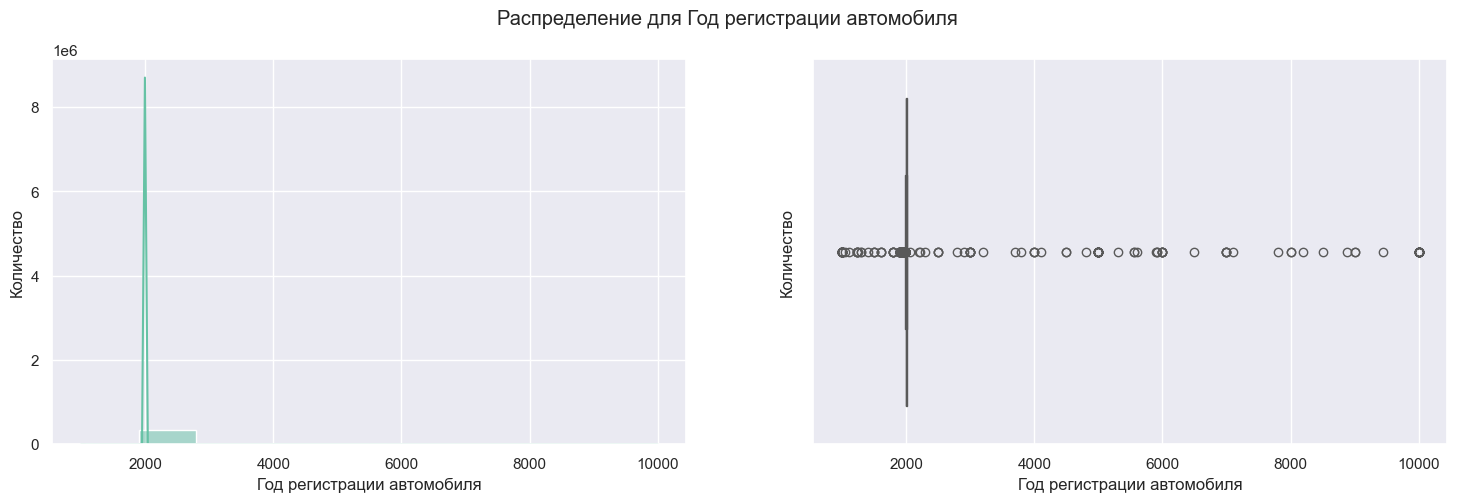

In [25]:
plot_distribution(autos, 'RegistrationYear', 'Год регистрации автомобиля')

Заметно некоторое количество выбросов. Отсеим неверную дату по логике - год регистрации автомобиля не может быть больше 2024, настоящего года, а также меньше 1886 - год получения патента Карлом Бенцем на первый автомобиль.

In [26]:

print(f"Кол-во нулевых строчек для признака цена: {len(autos.query('RegistrationYear < 1886 | RegistrationYear > 2024'))}, "
       f"их процент от общего числа {round(len(autos.query('RegistrationYear < 1886 | RegistrationYear > 2024')) / (autos['RegistrationYear'].shape[0]) * 100)}%")

Кол-во нулевых строчек для признака цена: 139, их процент от общего числа 0%


Поскольку этих данных немного, удалим их из датасета

In [27]:
autos = autos.query('RegistrationYear >= 1886 & RegistrationYear <= 2024')

Для обучения модели заменим дату регистрации на количество дней с момента регистрации на данный момент, чтобы преобразовать в относительное числовое значение

In [28]:
today = pd.Timestamp.now()
autos['DaysSinceToday'] = autos['DateCreated'].apply(lambda date: (today - date).days)
autos['DaysSinceToday'] = autos['DaysSinceToday'].astype('int')

In [29]:
autos.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysSinceToday
239447,2016-04-05 11:50:51,8300,sedan,2004,auto,218.0,5er,30000,4,gasoline,bmw,no,2016-04-05,0,93128,2016-04-05 11:50:51,3125
146979,2016-03-28 13:42:50,650,NaN,2000,manual,120.0,mondeo,150000,0,NaN,ford,NaN,2016-03-28,0,33729,2016-04-06 16:46:43,3133
260970,2016-03-11 18:43:15,1300,sedan,1994,manual,90.0,golf,150000,5,petrol,volkswagen,NaN,2016-03-11,0,33189,2016-03-17 04:45:20,3150
46757,2016-03-25 09:56:23,800,wagon,1999,NaN,75.0,cordoba,150000,0,NaN,seat,NaN,2016-03-25,0,66482,2016-03-29 22:46:57,3136
175801,2016-03-12 17:49:15,900,small,1996,auto,5.0,NaN,50000,0,petrol,sonstige_autos,NaN,2016-03-12,0,25836,2016-04-07 09:45:57,3149


Оставшиеся количественные признаки не будут рассматриваться для анализа. Далее необходимо проанализировать категориальные признаки

In [30]:
def categorial(df: pd.DataFrame, feature: str, feat_ru: str, threshold: float = 0.05):
    value_counts = df[feature].value_counts(normalize=True)
    others = value_counts[value_counts < threshold].index

    df_replaced = df[feature].replace(others, 'Others')
    data = df_replaced.value_counts().reset_index()
    data.columns = [feature, 'count']

    if len(data['count']) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(20, 4))
        fig.suptitle(f'Распределение для {feat_ru}')
        axes[0].yaxis.grid(True)

        sns.barplot(data=data, y=feature, x='count', ax=axes[0])
        axes[0].set_xlabel('Количество', fontsize=12)
        axes[0].set_ylabel(feat_ru, fontsize=12)

        axes[1].pie(data['count'], labels=data[feature], autopct='%.1f%%', radius=1)
    else:
        print(f'Для категориального признака "{feat_ru}" одинаковое количество данных на все группы: {data["count"][0]}')

#### Категориальные признаки

In [31]:
def calculate_na(df: pd.DataFrame, col: str):
    print(f'Количество пропущенных данных для {col} {len(df.loc[autos[col].isna()])}, '
          f'их процент от общего количества: {round(len(df.loc[df[col].isna()]) / df.shape[0] * 100)}%')

Пропуски в категориальных данных присутствуют среди признаков `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`

Рассмотрим каким образом можно их заменить и насколько большой процент они занимают

In [32]:
calculate_na(autos, 'VehicleType')

Количество пропущенных данных для VehicleType 33611, их процент от общего количества: 10%


Поскольку данных с пропущенным типом кузова слишом много для удаления, а тип кузова может быть различным для одной и той же модели, то будет правильнее указать, что данные не введены пользователем. Заменим значения на 'Notfilled'

In [33]:
autos["VehicleType"].fillna('Notfilled', inplace=True)

Рассмотрим теперь тип коробки передач: `GearBox`

In [34]:
calculate_na(autos, 'Gearbox')

Количество пропущенных данных для Gearbox 17243, их процент от общего количества: 5%


Поскольку в отличии от типа кузова, типов коробки передач всего два, с большей вероятностью мы укажем нужную, если вместо пропуска укажем наиболее распространенную коробку передач для модели

In [35]:
pivot = autos.pivot_table(index='Model', columns='Gearbox', aggfunc='size', fill_value=0)

most_frequent_gearbox = pivot.idxmax(axis=1)

autos['Gearbox'] = autos.apply(lambda row: most_frequent_gearbox[row['Model']] if (pd.isna(row['Gearbox']) and row['Model'] in most_frequent_gearbox) else row['Gearbox'],
                               axis=1)

In [36]:
calculate_na(autos, 'Gearbox')

Количество пропущенных данных для Gearbox 3038, их процент от общего количества: 1%


Оставшиеся пропущенные значения удалим, поскольку их нельзя заполнить наиболее встречающимся значением

In [37]:
autos.dropna(subset=['Gearbox'], inplace=True)

Рассмотрим теперь пропущенные данные для модели автомобиля

In [38]:
calculate_na(autos, 'Model')

Количество пропущенных данных для Model 14430, их процент от общего количества: 4%


Поскольку эти данные нельзя восстановить по бренду и их не так много, удалим их

In [39]:
autos.dropna(subset=['Model'], inplace=True)

Рассмотрим пропуски тип топлива `FuelType`

In [40]:
calculate_na(autos, 'FuelType')

Количество пропущенных данных для FuelType 23490, их процент от общего количества: 7%


Поскольку для одной и тоже модели могут быть реализованы разные типы топлива, а их вариация больше двух и тип топлива может влиять на ценообразование автомобиля, поскольку в зависимости от региона могут быть определенные предпочтения, а также тип топлива влияет на эксплуатационный износ, эти данные заполним как `Notfilled`

In [41]:
autos['FuelType'].fillna('Notfilled', inplace=True)

Рассмотрим пропуски для `Repaired`

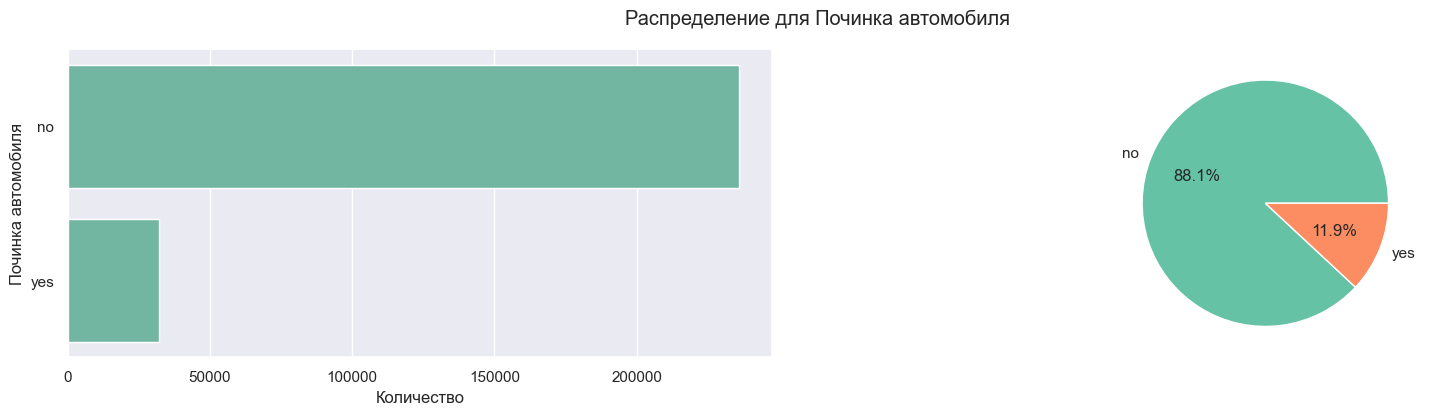

In [42]:
categorial(autos, 'Repaired', 'Починка автомобиля')

In [43]:
calculate_na(autos, 'Repaired')

Количество пропущенных данных для Repaired 58218, их процент от общего количества: 18%


Поскольку большаяя часть автомобилей не была в ремоне, а данное поле может быть не обязательным для заполнения при каких-то условиях, то логично будет заполнить данный признак `no`, поскольку машина не была в ремонте

In [44]:
autos["Repaired"].fillna('no', inplace=True)

Рассмотрим fuel_type, для этого построим график

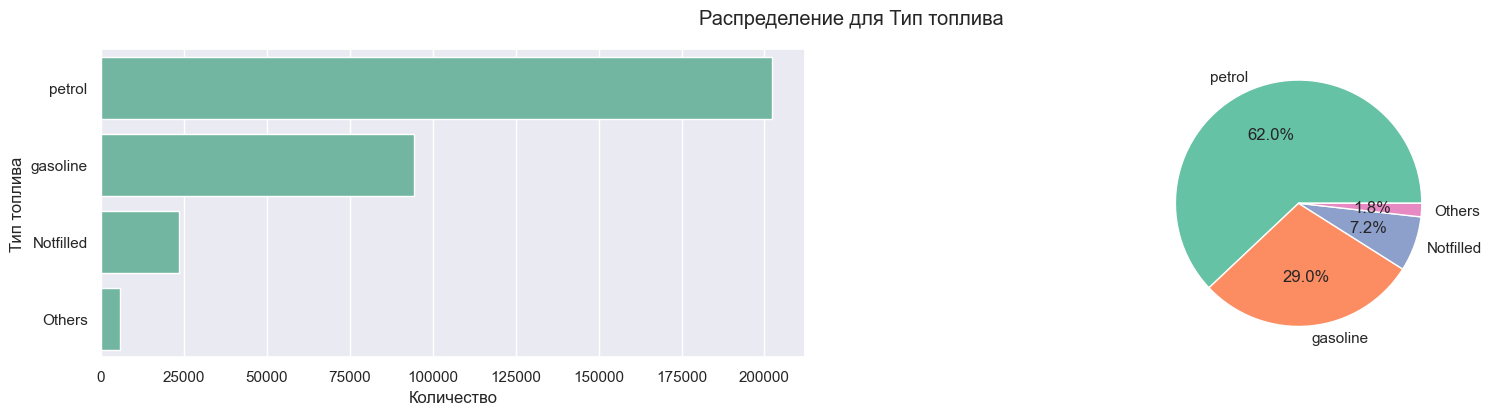

In [45]:
categorial(autos, 'FuelType', 'Тип топлива')

In [46]:
autos['FuelType'].value_counts()

FuelType
petrol       202235
gasoline      94500
Notfilled     23490
lpg            4845
cng             533
hybrid          204
other           118
electric         65
Name: count, dtype: int64

Обратим внимание, что 31% от общего числа занимает тип топлива gasoline, термин исходит из США. Соответственно можно предположить, что данные автомобили либо были куплены в Америке, либо использовались в данном регионе.

Поскольку термин petrol и gasoline означают одно и то же, объединим в одну категорию

In [47]:
autos['FuelType'] = autos['FuelType'].replace({'gasoline': 'petrol'})

In [48]:
autos['FuelType'].value_counts()

FuelType
petrol       296735
Notfilled     23490
lpg            4845
cng             533
hybrid          204
other           118
electric         65
Name: count, dtype: int64

#### Дубликаты

Рассмотрим какое количество дубликатов осталось после обработки признаков

In [49]:
autos[autos.duplicated(keep=False)].count()

DateCrawled          10
Price                10
VehicleType          10
RegistrationYear     10
Gearbox              10
Power                10
Model                10
Kilometer            10
RegistrationMonth    10
FuelType             10
Brand                10
Repaired             10
DateCreated          10
NumberOfPictures     10
PostalCode           10
LastSeen             10
DaysSinceToday       10
dtype: int64

Данное количество дубликатов позволяет избавится от них без лишних раздумий

In [50]:
autos.drop_duplicates(inplace=True)

Ранее мы отметили что `PostalCode`, `LastSeen`, `NumberOfPictures` не вляют на стоимость продажи, а также заменили `DateCreated` на относительную величину `DaysSinceToday`. Соответственно эти колонки можно удалить 

In [51]:
autos.drop(columns=['PostalCode', 'LastSeen', 'NumberOfPictures', 'DateCreated'], inplace=True)
autos.reset_index(drop=True)
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325985 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        325985 non-null  datetime64[ns]
 1   Price              325985 non-null  int64         
 2   VehicleType        325985 non-null  object        
 3   RegistrationYear   325985 non-null  int64         
 4   Gearbox            325985 non-null  object        
 5   Power              325985 non-null  float64       
 6   Model              325985 non-null  object        
 7   Kilometer          325985 non-null  int64         
 8   RegistrationMonth  325985 non-null  int64         
 9   FuelType           325985 non-null  object        
 10  Brand              325985 non-null  object        
 11  Repaired           325985 non-null  object        
 12  DaysSinceToday     325985 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64

In [52]:
autos['DateCrawled'] = autos['DateCrawled'].astype('int64')

In [53]:
def correlation_matrix(df: pd.DataFrame, columns: list, df_name: str) -> None:
    plt.figure(figsize=(12, 10))  
    figure = sns.heatmap(df.corr(method='spearman', numeric_only=True), 
                annot=True, 
                cmap='seismic', 
                fmt=".2f")
    figure.set_title(f'Матрица корреляции количественных признаков для датафрейма {df_name} по методу Спирмена')
    plt.tight_layout()

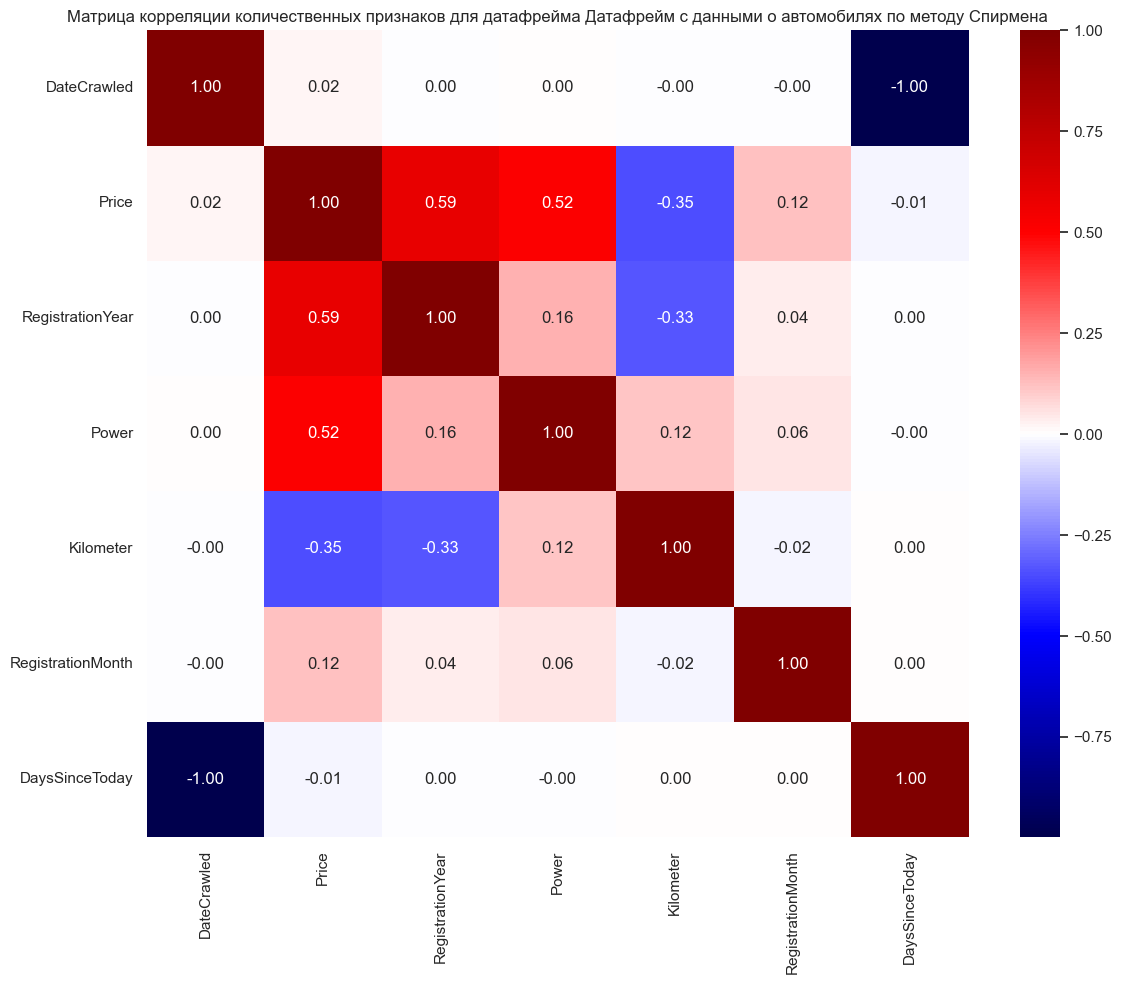

In [54]:
correlation_matrix(autos, ['DateCrawled', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'DaysSinceToday'], 'Датафрейм с данными о автомобилях')

Наблюдается сильная корреляция между `price` и `Power`, `RedistrationYear`

*Вывод:*
- Для количественных признаков:
    - были удалены данные с нулевой ценой, а также с некорректными значениями для мощности двигателя
- Для категориальных данных:
    - для коробки передач, где это было возможно, пропученные значения были заполнены на наиболее встречающееся для модели
    - для типа кузова, типа топлива, а также незаполненных значений коробки передач пропуски были заполнены как `NotFilled`
    - для признака ремонта пропуски были заполнены как `no`, то есть починка не проводилась
- Для данных типа datetime была произведена замена на относительную величину разница в днях для сегодняшнего дня
- были удалены дубликаты
- были удалены признаки, которые не будут использоваться в обучении `PostalCode`, `LastSeen`, `NumberOfPictures`, `DateCreated`
- была построена матрица корреляции, на которой заметна сильная корреляция между `price` и `Power`, `RedistrationYear`

### Кодирование данных и создание пайплайна

Поскольку сдреди обучаемых моделей планируется использовать градиентный бустинг, используем в качестве кодировщика TargetEncoder

In [55]:
X = autos.drop(columns=['Price'])
y = autos['Price']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE)

In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244488 entries, 307262 to 323801
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        244488 non-null  int64  
 1   VehicleType        244488 non-null  object 
 2   RegistrationYear   244488 non-null  int64  
 3   Gearbox            244488 non-null  object 
 4   Power              244488 non-null  float64
 5   Model              244488 non-null  object 
 6   Kilometer          244488 non-null  int64  
 7   RegistrationMonth  244488 non-null  int64  
 8   FuelType           244488 non-null  object 
 9   Brand              244488 non-null  object 
 10  Repaired           244488 non-null  object 
 11  DaysSinceToday     244488 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(6)
memory usage: 23.3+ MB


In [57]:
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
categories = [
    ['nan', 'bus', 'convertible', 'coupe', 'suv', 'sedan', 'small', 'wagon'],
    ['auto', 'manual'],
    ['1_reihe', '1er', '2_reihe', '3_reihe', '3er', '4_reihe', '5_reihe', '5er', '6_reihe', '6er', '7er', '80', '90',
     '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'accord', 'agila', 'alhambra', 'almera', 'alto', 'amarok',
     'antara', 'arosa', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
     'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'cadillac', 'calibra', 'carisma', 'carnival',
     'cashqai', 'c_ceer', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'cl', 'clio', 'clk', 'clubman', 'colt',
     'combo', 'cordoba', 'corolla', 'corsa', 'coupe', 'crossfire', 'cx_reihe', 'defender', 'delta', 'discovery',
     'doblo', 'ducato', 'duster', 'elefantino', 'elantra', 'espace', 'exeo', 'f_pace', 'fabia', 'fiesta', 'focus',
     'forester', 'fortwo', 'frogeye', 'fusion', 'g_klasse', 'galant', 'galaxy', 'gl', 'glk', 'golf', 'grand', 'grande',
     'i3', 'i_reihe', 'iomanz', 'ion', 'jetta', 'jimny', 'justy', 'ka', 'kadett', 'kaefer', 'kalina', 'kalos', 'kangoo',
     'kappa', 'karl', 'kiacarens', 'kiaceed', 'kiamagentis', 'kiapicanto', 'kiari', 'kiarondo', 'kiasedona', 'kiashuma',
     'kiavenga', 'kiavista', 'kiacerato', 'kiamohave', 'kiaopirus', 'kiario', 'kiastonic', 'kiavenga', 'kiaviero',
     'kiamegara', 'kiarodeo', 'kiacarens', 'laguna', 'lanos', 'legacy', 'leon', 'logan', 'lorry', 'lupo', 'lybra',
     'm_klasse', 'm_reihe', 'matiz', 'maxima', 'megane', 'meriva', 'mini', 'mondeo', 'move', 'musa', 'mx-5', 'mystery',
     'nan', 'navara', 'niva', 'note', 'nubira', 'omega', 'one', 'other', 'outback', 'outlander', 'pajero', 'panda',
     'passat', 'phaedra', 'picanto', 'polo', 'primera', 'ptcruiser', 'puma', 'q7', 'r19', 'rav', 'rondo', 'roomster',
     'royal', 'rx8', 's_type', 'samara', 'sandero', 'santa', 'scenic', 'sedici', 'sentra', 'sephia', 'serie2', 'serie3',
     'shuma', 'siballa', 'sierra', 'sirion', 'sl', 'slk', 'smax', 'sonic', 'sorento', 'spark', 'space', 'spirit',
     'sport', 'sportage', 'sprinter', 'stilo', 'streetka', 'sunny', 'swift', 'sx4', 'taiga', 'terios', 'tiguan',
     'toledo', 'touran', 'toureg', 'transit', 'trevi', 'tribeca', 'trooper', 'tunderbird', 'twigo', 'up', 'utrack',
     'vectra', 'vento', 'viano', 'vivalo', 'voyager', 'vrs', 'xtor', 'xtrail', 'yaris', 'zenos', 'zilos', 'zirossa',
     'zizil'],
    ['nan', 'a6', 'a_klasse', 'agila', 'auris', 'avensis', 'aygo', 'b_max', 'beetle', 'berlingo', 'bmw320i', 'bmw330ci',
     'bmw335d', 'bmw645', 'bmw760', 'c6', 'corolla', 'cordoba', 'corsa', 'corolla', 'crossfire', 'flax', 'frogeye',
     'gl', 'glk', 'golf4', 'golf6', 'golfgti', 'honda', 'jazz', 'karl', 'kiaev6', 'lete', 'mahw', 'mi1', 'mondeo',
     'mx5', 'nan', 'oppon', 'pajero', 'peugeot2008', 'picanto', 'polo', 'renaultclio', 'rx8', 'sandero', 'sedici',
     'sephia', 'serie3', 'shuma', 'siballa', 'sie', 'sunny', 'swift', 'suzuki', 'terios', 'tiaga', 'totota', 'touran',
     'tow', 'transit', 'tribeca', 'trooper', 'u-sport', 'viano', 'warth', 'x3i', 'x5umma', 'xus', 'yaris', 'ziggity'],
    ['nano', 'disco', 'gas'],
    ['hybrid', 'lpg', 'petrol', 'internal', 'external']
]

In [58]:
cat_cols

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [59]:

num_pipe = Pipeline([
    ('Imputer_before', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])

oe_pipe = Pipeline([
    ('Imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=categories, 
                                   handle_unknown='use_encoded_value', 
                                   unknown_value=np.nan)),
    ('after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

ohe_pipe = Pipeline([
    ('Imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

preprocessor_oe = ColumnTransformer([
    ('num_processing', num_pipe, num_cols),
    ('cat_processing', oe_pipe, cat_cols),

], remainder='passthrough')

preprocessor_ohe = ColumnTransformer([
    ('num_processing', num_pipe, num_cols),
    ('cat_processing', ohe_pipe, cat_cols),

], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', preprocessor_oe),
    ('model', LGBMRegressor(random_state=RANDOM_STATE))
])

params_grid = [
    {
        'preprocessor': [preprocessor_ohe],
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__solver':['auto', 'sparse_cg', 'lsqr'],
        'preprocessor__num_processing__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()]
    },
    {
        'preprocessor': [preprocessor_oe],
        'model': [LGBMRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': range(500, 900, 100),
        'model__learning_rate': [0.1],
        'model__max_depth': [7],
        'preprocessor__num_processing__scaler': [RobustScaler(), MinMaxScaler()]
    },
    {
        'preprocessor': [preprocessor_oe],
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 10],
        'model__min_samples_leaf': [1, 10],
    }
]

Был собран пайплайн для основных простых типов моделей, а также градиентного бустинга в модели LGBMRegressor

## Обучение моделей

In [60]:
rs_search = RandomizedSearchCV(pipe_final,
                               params_grid,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1,
                               random_state=RANDOM_STATE,
                               n_iter=10
                               )
rs_search.fit(X_train, y_train)

c:\Users\taras\anaconda3\envs\practicum\lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: [3 4 5]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 244488, number of used features: 9
[LightGBM] [Info] Start training from score 4621.633716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_processing',
                                                                               Pipeline(steps=[('Imputer_before',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['DateCrawled',
                                                                                'RegistrationYear',
                                                                                'Power',
                                                                                'Kilometer',
                                                                                'RegistrationMonth',
                                                                                'DaysSinceToday']),
                                                                              ('cat_processing',
                                                                               Pipeli...
                                                                                                                                        'glk',
                                                                                                                                        'golf4',
                                                                                                                                        'golf6',
                                                                                                                                        'golfgti',
                                                                                                                                        'honda',
                                                                                                                                        'jazz', ...],
                                                                                                                                       ['nano',
                                                                                                                                        'disco',
                                                                                                                                        'gas'],
                                                                                                                                       ['hybrid',
                                                                                                                                        'lpg',
                                                                                                                                        'petrol',
                                                                                                                                        'internal',
                                                                                                                                        'external']],
                                                                                                                           handle_unknown='use_encoded_value',
                                                                                                                           unknown_value=nan)),
                                                                                                           ('after',
                                                           

In [61]:
rs_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_processing',
                                                  Pipeline(steps=[('Imputer_before',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['DateCrawled',
                                                   'RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'DaysSinceToday']),
                                                 ('cat_processing',
                                                  Pipeline(steps=[('Imputer_before',
                                                                   Sim...
                                                                                               'golf6',
                                                                                               'golfgti',
                                                                                               'honda',
                                                                                               'jazz', ...],
                                                                                              ['nano',
                                                                                               'disco',
                                                                                               'gas'],
                                                                                              ['hybrid',
                                                                                               'lpg',
                                                                                               'petrol',
                                                                                               'internal',
                                                                                               'external']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired'])])),
                ('model',
                 LGBMRegressor(max_depth=7, n_estimators=700, random_state=5))])

In [62]:
best_decision = rs_search.best_estimator_
best_model = best_decision.named_steps['model']
best_params = rs_search.best_params_

In [63]:
results = pd.DataFrame(rs_search.cv_results_).sort_values(by='rank_test_score', ascending=True).head(10)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num_processing__scaler,param_preprocessor,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model,...,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,55.655268,6.758940,0.915116,0.119712,RobustScaler(),"ColumnTransformer(remainder='passthrough',\n ...",700,7,0.1,LGBMRegressor(random_state=5),...,NaN,{'preprocessor__num_processing__scaler': Robus...,-1799.985010,-1785.055907,-1784.671442,-1767.494157,-1799.369819,-1787.315267,11.923133,1
0,112.465857,12.061397,1.600819,1.314572,RobustScaler(),"ColumnTransformer(remainder='passthrough',\n ...",600,7,0.1,LGBMRegressor(random_state=5),...,NaN,{'preprocessor__num_processing__scaler': Robus...,-1806.659198,-1792.334272,-1789.667338,-1773.335484,-1805.209800,-1793.441219,12.107209,2
5,37.115845,4.009717,1.048096,0.109544,MinMaxScaler(),"ColumnTransformer(remainder='passthrough',\n ...",500,7,0.1,LGBMRegressor(random_state=5),...,NaN,{'preprocessor__num_processing__scaler': MinMa...,-1818.149203,-1797.660254,-1791.657907,-1780.945827,-1811.508433,-1799.984325,13.416131,3
1,27.170087,2.012574,0.940517,0.624075,NaN,"ColumnTransformer(remainder='passthrough',\n ...",NaN,20,NaN,DecisionTreeRegressor(random_state=5),...,NaN,{'preprocessor': ColumnTransformer(remainder='...,-2006.642959,-1993.655958,-1998.410811,-1992.122299,-1984.929633,-1995.152332,7.191328,4
9,6.398464,0.292877,0.383929,0.041660,NaN,"ColumnTransformer(remainder='passthrough',\n ...",NaN,None,NaN,DecisionTreeRegressor(random_state=5),...,NaN,{'preprocessor': ColumnTransformer(remainder='...,-2009.241922,-1996.984429,-2001.721964,-1994.464874,-1988.643662,-1998.211370,6.943774,5
2,11.479530,4.820953,1.076377,0.867377,NaN,"ColumnTransformer(remainder='passthrough',\n ...",NaN,10,NaN,DecisionTreeRegressor(random_state=5),...,NaN,{'preprocessor': ColumnTransformer(remainder='...,-2085.957686,-2060.604877,-2054.985167,-2063.784208,-2054.889046,-2064.044197,11.471533,6
3,6.424909,0.312538,0.398613,0.038016,NaN,"ColumnTransformer(remainder='passthrough',\n ...",NaN,10,NaN,DecisionTreeRegressor(random_state=5),...,NaN,{'preprocessor': ColumnTransformer(remainder='...,-2101.964910,-2066.639101,-2068.347514,-2070.347889,-2070.034083,-2075.466699,13.315254,7
4,7.728718,0.065979,0.362469,0.024587,NaN,"ColumnTransformer(remainder='passthrough',\n ...",NaN,20,NaN,DecisionTreeRegressor(random_state=5),...,NaN,{'preprocessor': ColumnTransformer(remainder='...,-2171.556188,-2155.155035,-2137.847670,-2153.007325,-2143.625696,-2152.238383,11.519954,8
8,14.514148,5.222370,0.503743,0.251692,NaN,"ColumnTransformer(remainder='passthrough',\n ...",NaN,20,NaN,DecisionTreeRegressor(random_state=5),...,NaN,{'preprocessor': ColumnTransformer(remainder='...,-2311.145454,-2329.270742,-2292.522778,-2321.716668,-2326.816078,-2316.294344,13.417107,9
6,6.044782,0.204362,0.294769,0.011946,MinMaxScaler(),"ColumnTransformer(remainder='passthrough',\n ...",NaN,NaN,NaN,Ridge(random_state=5),...,auto,{'preprocessor__num_processing__scaler': MinMa...,-2694.096997,-2680.517427,-2663.228149,-2672.595335,-2678.075165,-2677.702615,10.123558,10


In [64]:
print('Лучшая модель и её параметры:\n\n', best_decision)
print(f'Метрика precision лучшей модели по кросс-валидации на обучающих данных: {round(rs_search.best_score_, 2)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_processing',
                                                  Pipeline(steps=[('Imputer_before',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['DateCrawled',
                                                   'RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'DaysSinceToday']),
                                                 ('cat_processing',
                                    

Основываясь на результатах кросс-валидации, метрика RMSE первых трех моделей отличается незначительно, однако третья модель показыает меньшее время для обучения (mean_fit_time=22.958248) и вычисления метрики качества (mean_score_time = 1.744146) при метрике (mean_test_score=1801.118467). Следовательно, именно эта модель подходит лучше, чем остальные, оценим ее время предсказания.

In [65]:
chosen_params = rs_search.cv_results_['params'][7]

In [66]:
new_preprocessor = ColumnTransformer([
    ('num_processing', Pipeline([
        ('Imputer_before', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', RobustScaler())
    ]), num_cols),
    ('cat_processing', Pipeline([
        ('Imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder', OrdinalEncoder(categories=categories, 
                                   handle_unknown='use_encoded_value', 
                                   unknown_value=np.nan)),
        ('after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]), cat_cols)
], remainder='passthrough')

pipe_alternative = Pipeline([
    ('preprocessor', new_preprocessor), 
    ('model',  LGBMRegressor(max_depth=6, n_estimators=500, random_state=5, learning_rate=0.1))
])

pipe_alternative

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_processing',
                                                  Pipeline(steps=[('Imputer_before',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['DateCrawled',
                                                   'RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'DaysSinceToday']),
                                                 ('cat_processing',
                                                  Pipeline(steps=[('Imputer_before',
                                                                   Sim...
                                                                                               'golf6',
                                                                                               'golfgti',
                                                                                               'honda',
                                                                                               'jazz', ...],
                                                                                              ['nano',
                                                                                               'disco',
                                                                                               'gas'],
                                                                                              ['hybrid',
                                                                                               'lpg',
                                                                                               'petrol',
                                                                                               'internal',
                                                                                               'external']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired'])])),
                ('model',
                 LGBMRegressor(max_depth=6, n_estimators=500, random_state=5))])

In [67]:
%%time

pipe_alternative.fit(X_train, y_train)

c:\Users\taras\anaconda3\envs\practicum\lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: [3 4 5]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 244488, number of used features: 9
[LightGBM] [Info] Start training from score 4621.633716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_processing',
                                                  Pipeline(steps=[('Imputer_before',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['DateCrawled',
                                                   'RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'DaysSinceToday']),
                                                 ('cat_processing',
                                                  Pipeline(steps=[('Imputer_before',
                                                                   Sim...
                                                                                               'golf6',
                                                                                               'golfgti',
                                                                                               'honda',
                                                                                               'jazz', ...],
                                                                                              ['nano',
                                                                                               'disco',
                                                                                               'gas'],
                                                                                              ['hybrid',
                                                                                               'lpg',
                                                                                               'petrol',
                                                                                               'internal',
                                                                                               'external']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired'])])),
                ('model',
                 LGBMRegressor(max_depth=6, n_estimators=500, random_state=5))])

*Вывод*:
- При помощи метода RandomizedSearchCV были перебраны гиперпараметры моделей DecisionTreeRegressor, LGBMRegressor, KNeighborsRegressor, Ridge
- Категориальные признаки были закодированы при помощи OrdinalEncoder, количественые - при помощи StandardScaler(), RobustScaler(), MinMaxScaler()
- был выбран лучшим LGBMRegressor(max_depth=6, n_estimators=500, random_state=5, learning_rate=0.1) с RMSE 1798

In [68]:
%%time

y_pred = pipe_alternative.predict(X_test)

c:\Users\taras\anaconda3\envs\practicum\lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: [3 4 5]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 5.58 s
Wall time: 985 ms


In [69]:
print(f'Результат RMSE на тестовых данных {round(mean_squared_error(y_test, y_pred, squared=False))}')

Результат RMSE на тестовых данных 1815


## Вывод

- На этапе исследовательского анализа и предобработки данных:
    - Для количественных признаков:
        - были удалены данные с нулевой ценой, а также с некорректными значениями для мощности двигателя
    - Для категориальных данных:
        - для коробки передач, где это было возможно, пропученные значения были заполнены на наиболее встречающееся для модели
        - для типа кузова, типа топлива, а также незаполненных значений коробки передач пропуски были заполнены как `NotFilled`
        - для признака ремонта пропуски были заполнены как `no`, то есть починка не проводилась
    - Для данных типа datetime была произведена замена на относительную величину разница в днях для сегодняшнего дня
    - были удалены дубликаты
    - были удалены признаки, которые не будут использоваться в обучении `PostalCode`, `LastSeen`, `NumberOfPictures`, `DateCreated`
    - была построена матрица корреляции, на которой заметна сильная корреляция между `price` и `Power`, `RedistrationYear`
- На этапе обучения моделей:
    - При помощи метода RandomizedSearchCV были перебраны гиперпараметры моделей DecisionTreeRegressor, LGBMRegressor, KNeighborsRegressor, Ridge
    - Категориальные признаки были закодированы при помощи OrdinalEncoder, количественые - при помощи StandardScaler(), RobustScaler(), MinMaxScaler()
    - был выбран лучшим LGBMRegressor(max_depth=6, n_estimators=500, random_state=5, learning_rate=0.1) с RMSE 1798
- На этапе тестирования модели:
    - был получен результат RMSE 1800 на тестовых данных